# Make forward model (Y) with AVISO data

In [1]:
import numpy as np
import scipy
import xarray as xr
import cmocean as cmo
import matplotlib.pyplot as plt

In [2]:
from aviso_rossby_wave import skill_matrix, reverse_vector
from aviso_rossby_wave import make_ssh_predictions, inversion

## Starting Date

In [3]:
day0, day1 = 0, 1

### Stratification paramters

## Subset 10 degree by 10 degree of ocean
### the aviso data is sampled at 5-day intervals

In [4]:
lonidx_west, lonidx_east = 60, 100
latidx_south, latidx_north = 34, 74

In [5]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north, lonidx_west:lonidx_east, :]
T_time = avisso_ds.time.data[day0:] * 86400

In [6]:
date_time = avisso_ds.date_time.data[day0:]
date_time[0]

numpy.datetime64('2016-06-01T00:00:00.000000000')

In [7]:
ssha_time_mean = SSHA.mean(axis = -1)

In [8]:
SSHA = SSHA - SSHA.mean(axis = -1) - SSHA.mean(axis = 0)
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked)

#### MSLA is the AVISO SSH anomalies to fit

In [9]:
MSLA0 = SSHA_masked[:, :, day0:day1]

In [10]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

### parameters

In [11]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

#### Rossby wave vertical modes

In [12]:
MModes = 1

#### define wavenumber interval based on domain size

In [13]:
L_lat = 10 # domain latitude length 
L_lon = 10 # domain lognitude length

domain_factor = 1.5

k_interval = 2 * np.pi / (domain_factor * L_lat) # k wavemenumber interval
l_interval = 2 * np.pi / (domain_factor * L_lon)

lamda_min = .5 # 100km = 1 degree
k_min = 0
k_max = 2 * np.pi / lamda_min
l_max = k_max
l_min = -1 * l_max

In [14]:
k_n_orig = np.arange(k_min, k_max, k_interval) # degree^-1
l_n_orig = np.arange(l_min, l_max, l_interval) # degree^-1
k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)

In [15]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [16]:
Psi = strat_ds.Psi.data
wavespeed = strat_ds.C2[:MModes].data
Rm = wavespeed / f0 / 1e5 # unit: degree
wavespeed, Rm

(array([8.12455163]), array([1.88539712]))

#### evalucate the skill of each wave

In [17]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time)

100%|██████████████████████████████████████| 1800/1800 [00:07<00:00, 240.30it/s]


#### Number of models/waves

In [18]:
M = l_n.size * k_n.size

In [19]:
kk, ll = np.meshgrid(k_n, l_n)

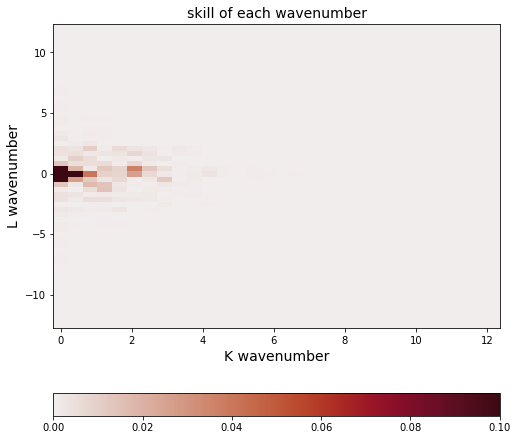

In [20]:
plt.figure(figsize = (8, 8))
plt.pcolor(kk, ll, skill[:, :, 0].T, cmap = cmo.cm.amp, vmin = 0, vmax = 0.1)
plt.xlabel('K wavenumber', fontsize = 14)
plt.ylabel('L wavenumber', fontsize = 14)
plt.colorbar(orientation = 'horizontal')
plt.title('skill of each wavenumber', fontsize = 14)
plt.savefig('./skill_matrix_KLwaves_' + str(M) + '.png')

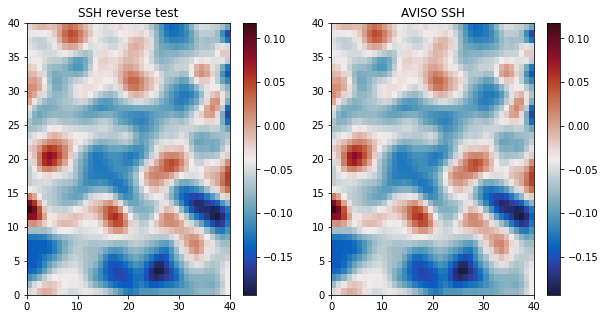

In [21]:
ssha_inverse = reverse_vector(MSLA0, SSHA_vector)
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.title('SSH reverse test')
plt.pcolormesh(ssha_inverse[:, :, 0], cmap = cmo.cm.balance)
plt.colorbar()
plt.subplot(122)
plt.title('AVISO SSH')
plt.pcolormesh(MSLA0[:, :, 0], cmap = cmo.cm.balance)
plt.colorbar()

#### Signal to noise ratio matrix

In [22]:
P_over_R = np.eye(2 * M, 2 * M)
for ii in range(2 * M):    
    P_over_R[ii, ii] = 0.002

#### Build basis function H matrix

In [23]:
    dlon = lon - lon.mean()
    dlat = lat - lat.mean()
    M = len(k_n) * len(l_n)
    H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
    H_all = np.zeros([len(SSHA_vector), M*2])
    omega = np.zeros([len(k_n), len(l_n), MModes])

    nn = 0 
    for kk in range(len(k_n)):
        for ll in range(len(l_n)):
            for mm in range(MModes):
                omega[kk, ll, mm] =  -1 * (Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)
                for count in range(len(Iindex)):
                    H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])]) 
                    H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk, mm] * dlon[int(Iindex[count])] + l_n[ll, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])])
                nn += 1

    H_all[:, 0::2] = H_cos 
    H_all[:, 1::2] = H_sin

#### solve for amplitudes

In [24]:
amp, ssh_estimated = inversion(SSHA_vector, H_all, P_over_R)

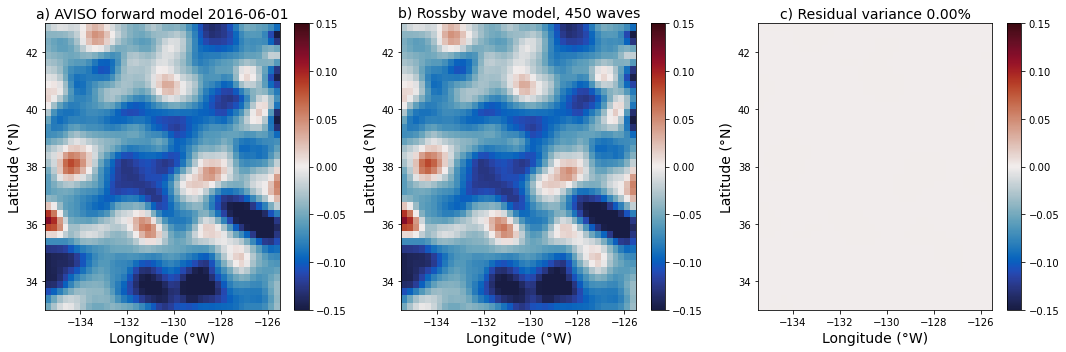

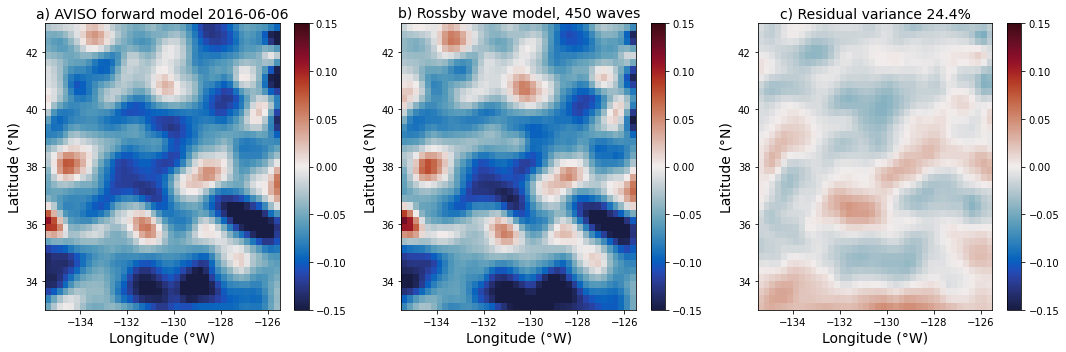

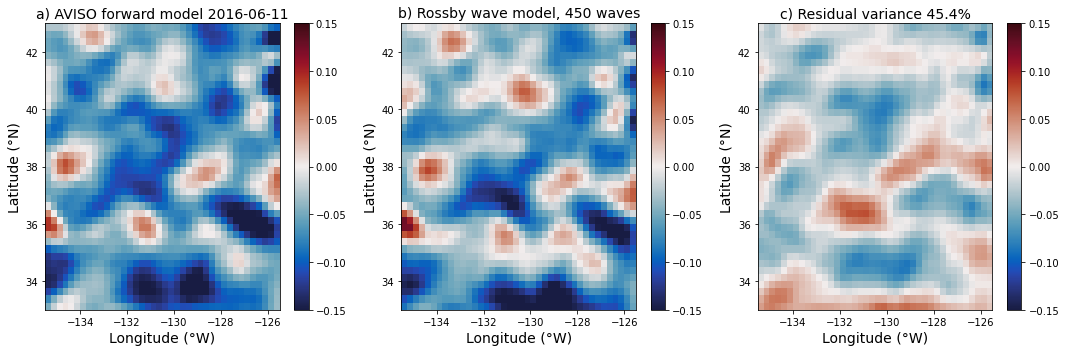

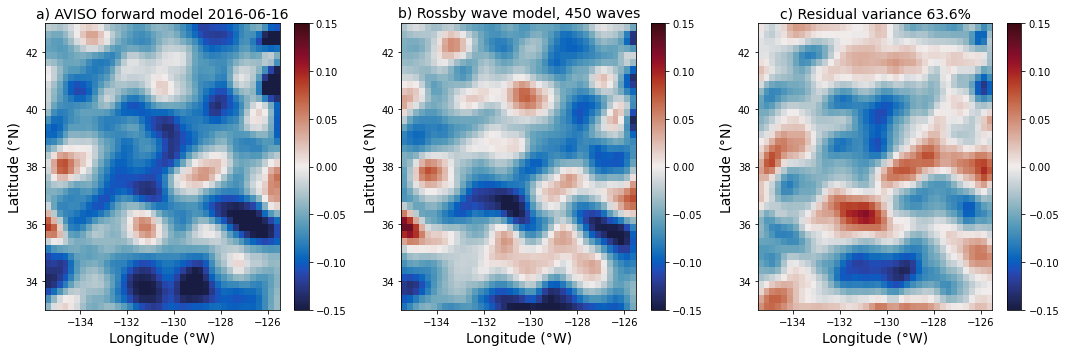

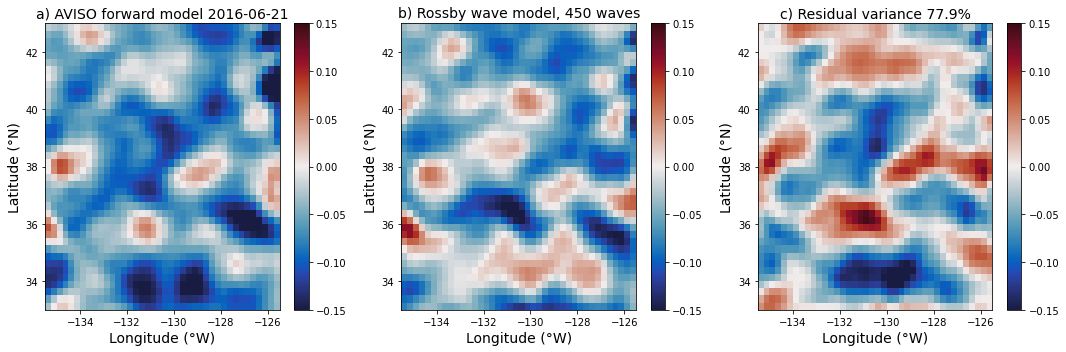

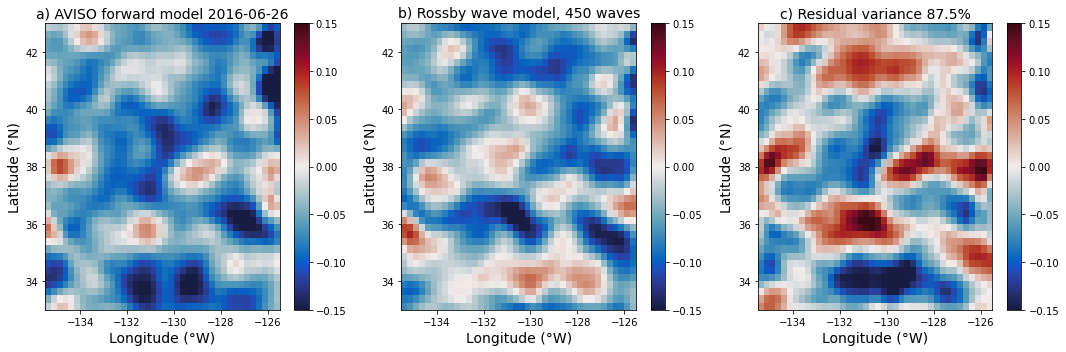

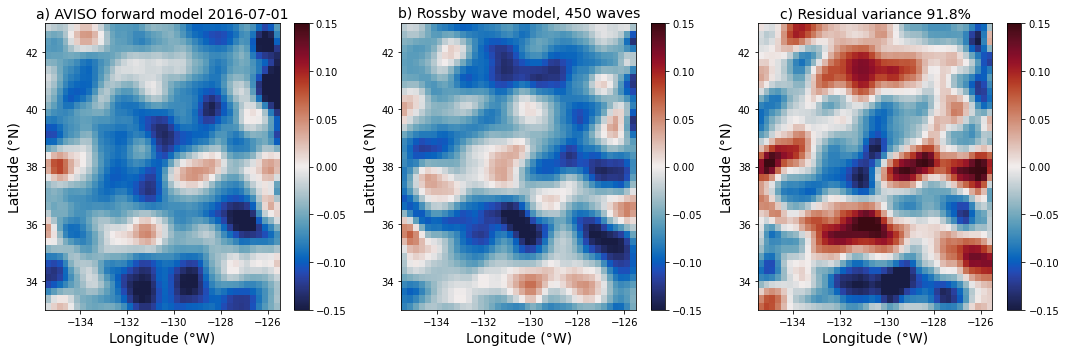

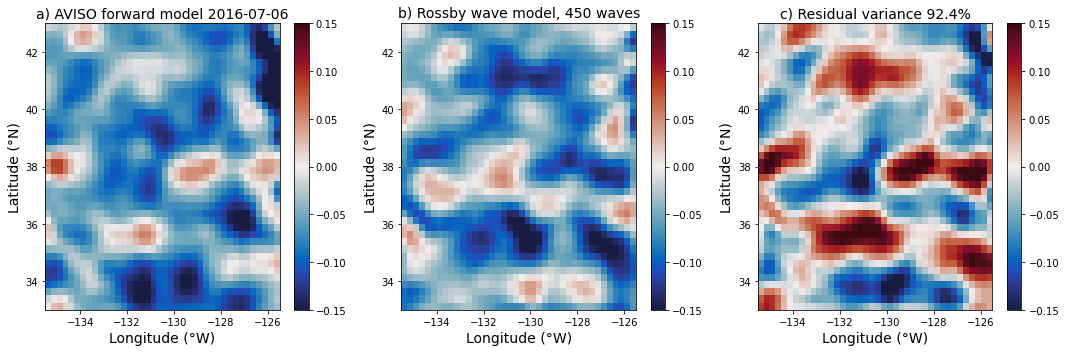

In [25]:
time_range = 8 ## 8 * 5 = 40 days
SSHA_predicted = np.zeros([time_range, MSLA0.size])
SSHA_true = np.zeros([time_range, MSLA0.size])
variance_explained_inverse = np.zeros(time_range)
MSLA_fwrd = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(0, time_range):
    MSLA = SSHA_masked[:,:,day0 + day:day0 + day + 1]
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = make_ssh_predictions(day, amp, MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm)
    MSLA_fwrd[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) #MSLA_fwd[:, :, day]
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    #plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, MSLA_fwrd[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) Rossby wave model, 450 waves', fontsize = 14)

    residual = MSLA[:, :, 0] - MSLA_fwrd[:, :, day] 
    plt.subplot(133)
    #plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' + str((1 - variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
    
    plt.tight_layout()
    #plt.close()
    plt.savefig('fwrd_ssh_' + str(date_time[day])[:10] +'_' + str(skill.size) + 'waves.png', dpi = 300)

In [26]:
ds_output = xr.Dataset(data_vars={'k_n' : k_n[:, 0],
                                  'l_n' : l_n[:, 0],
                                  'Amplitudes': amp,
                                  'variance_explained': (('time'), variance_explained_inverse),
                                  'MSLA_forward' : (('YC', 'XC', 'time'), MSLA_fwrd[:, :, :time_range]),
                                  'Rm': Rm,
                                  'XC' : (('XC'), lon.data), 
                                  'YC' : (('YC'), lat.data),
                                  'time': date_time[day:day+time_range]},
                      attrs = dict(description=('Data sample of the selected waves, amplitudes, estimated SSH anomalies and residual.')))

In [27]:
variance_explained_inverse

array([0.99999894, 0.75578651, 0.54527328, 0.36333755, 0.2206667 ,
       0.12449519, 0.08162508, 0.07531239])

In [28]:
ds_output.to_netcdf('./rossby_wave_estimate_' + str(date_time[0])[:10] +'_' + str(l_n.size * k_n.size) +'waves.nc')

### Plot the Rossby wave model versus the AVISO data

In [29]:
selected_lat = 20
selected_time = 8 # 5 * 8 = 40 days
time = T_time[:selected_time] / 86400
SSHA[selected_lat, :, :selected_time].shape

(40, 8)

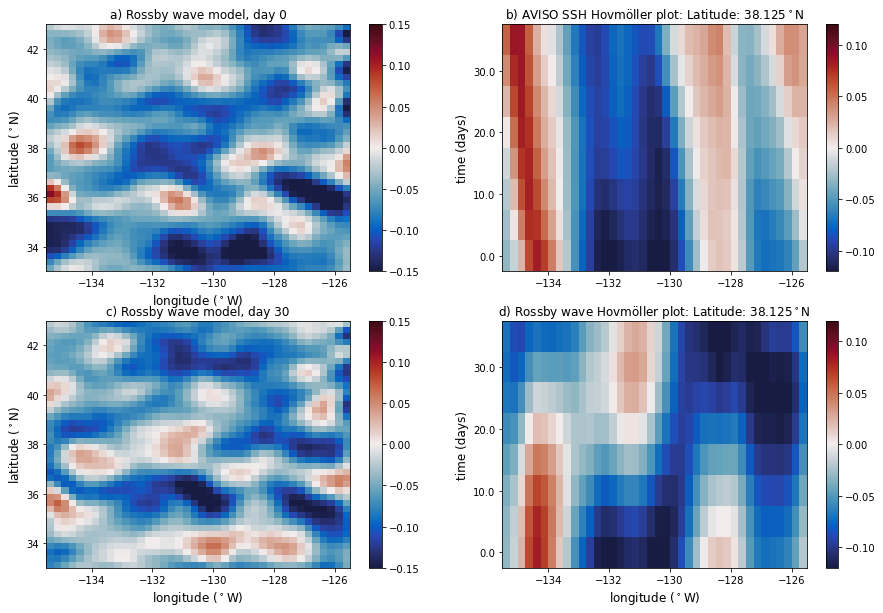

In [30]:
date1, date2 = 0, 6
plt.figure(figsize = (15, 10))
plt.subplot(221) 
plt.title('a) Rossby wave model, day '+ str(int(date1 * 5)))
plt.pcolormesh(lon, lat,  MSLA_fwrd[:, :, date1], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#plt.pcolormesh(lon, lat,  SSHA[:, :, day0+date1], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('latitude ($^\circ$N)', fontsize = 12)

plt.subplot(222) 
plt.title('b) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time,  SSHA[selected_lat, :, :selected_time].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.colorbar()
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])

plt.subplot(223) 
plt.title('c) Rossby wave model, day ' + str(int(date2 * 5)))
plt.pcolormesh(lon, lat,  MSLA_fwrd[:, :, date2], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('latitude ($^\circ$N)', fontsize = 12)

plt.subplot(224) 
plt.title('d) Rossby wave Hovmöller plot: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[selected_lat, :, :selected_time].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])
plt.savefig('fwrd_model' + str(l_n.size * k_n.size) + 'waves.png')

In [31]:
selected_lat = 11

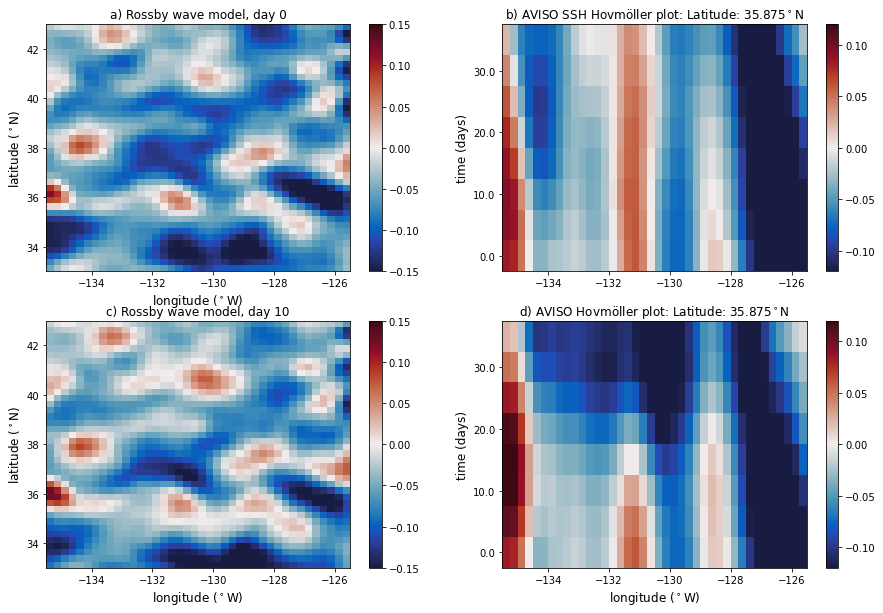

In [45]:
date1, date2 = 0, 2
plt.figure(figsize = (15, 10))
plt.subplot(221) 
plt.title('a) Rossby wave model, day '+ str(int(date1 * 5)))
plt.pcolormesh(lon, lat,  MSLA_fwrd[:, :, date1], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('latitude ($^\circ$N)', fontsize = 12)

plt.subplot(222) 
#plt.subplot(311)
plt.title('b) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time,  SSHA[selected_lat, :, :selected_time].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.colorbar()
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])

plt.subplot(223) 
plt.title('c) Rossby wave model, day ' + str(int(date2 * 5)))
plt.pcolormesh(lon, lat,  MSLA_fwrd[:, :, date2], cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('latitude ($^\circ$N)', fontsize = 12)

plt.subplot(224) 
plt.title('d) AVISO Hovmöller plot: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[selected_lat, :, :selected_time].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::2], time[0::2] - time[0])
plt.savefig('fwrd_model' + str(l_n.size * k_n.size) + 'waves.png')

## Diagnostics

### Phase speed is faster for longer waves. the maximum zonal phszase speed is Cx = $\beta * R^2$. For those waves, the propagration speed for the ROssby waves: 

In [33]:
Beta * Rm ** -2, 'degree/s'

(array([6.13180005e-07]), 'degree/s')

In [46]:
Beta * Rm ** -2 * .85e5 * 86400 * 20, 'm/s'




(array([90063.8791327]), 'm/s')

In [35]:
pwd

'/Users/yugao/Desktop/SWOT/cer-swot'

In [36]:
SSHA.shape

(40, 40, 150)

### Compare persistence error to forecast error: do wave dynamics predict SSH anomalies better than persistence? 

In [37]:
selected_time = 8

In [38]:
#persistence_err = MSLA_fwrd[:, :, :selected_time] - SSHA.data[:, :, day0:day1]
persistence = SSHA.data[:, :, day0:day0+selected_time] - SSHA.data[:, :, day0:day1]
prediction_err = MSLA_fwrd[:, :, :selected_time] - SSHA.data[:, :, :selected_time]

In [42]:
#rms_persistence_err = np.zeros(persistence_err.shape[-1])
rms_persistence = np.zeros(persistence_err.shape[-1])
rms_prediction_err = np.zeros(prediction_err.shape[-1])
for t in range(persistence_err.shape[-1]):
    #rms_persistence_err[t] = np.sqrt(np.mean(persistence_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_persistence[t] = np.sqrt(np.mean(persistence[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, t].data ** 2))

In [43]:
time, time[:selected_time].shape,  rms_prediction_err[:selected_time].shape

(array([736482., 736487., 736492., 736497., 736502., 736507., 736512.,
        736517.]),
 (8,),
 (8,))

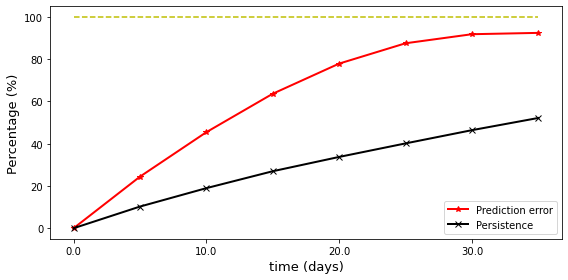

In [44]:
plt.figure(figsize = (8,4))
plt.plot(time[:selected_time],  rms_prediction_err[:selected_time] * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Prediction error')
plt.plot(time[:selected_time], (rms_persistence[:selected_time]) * 100,  
         '-x',linewidth = 2, color = 'k', label = 'Persistence')
plt.plot(time, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
plt.xticks(time[:selected_time][0::2], time[:selected_time][0::2] - time[0])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('time (days)', fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_err_vs_persistence_' + str(M) + '_waves.png', dpi = 300)